In [160]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import numpy as np
import matplotlib.pyplot as plt

In [161]:
# Load the model weights
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
quantization_grid = 0.1

print("Loading tokenizer and model for architecture...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
unquantized_model = AutoModelForSequenceClassification.from_pretrained(model_name)
model_OBC = AutoModelForSequenceClassification.from_pretrained(model_name)
model_naive = AutoModelForSequenceClassification.from_pretrained(model_name)

print("Loading model weights...")
unquantized_model.load_state_dict(torch.load("models/model_unquantized_weights_"+str(quantization_grid)+".pth"))
model_OBC.load_state_dict(torch.load("models/model_OBC_weights_"+str(quantization_grid)+".pth"))
model_naive.load_state_dict(torch.load("models/model_naive_weights_"+str(quantization_grid)+".pth"))

results = torch.load("results/results_"+str(quantization_grid)+".pth")

result_types = ["weight_approximation_error_OBC", "reconstruction_error_OBC", "weight_approximation_error_naive", "reconstruction_error_naive"]
layer_idx = ['layer_0', 'layer_1', 'layer_2', 'layer_3']
layer_types = ["query", "key", "value", "proj", "intermediate", "output"]

Loading tokenizer and model for architecture...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model weights...


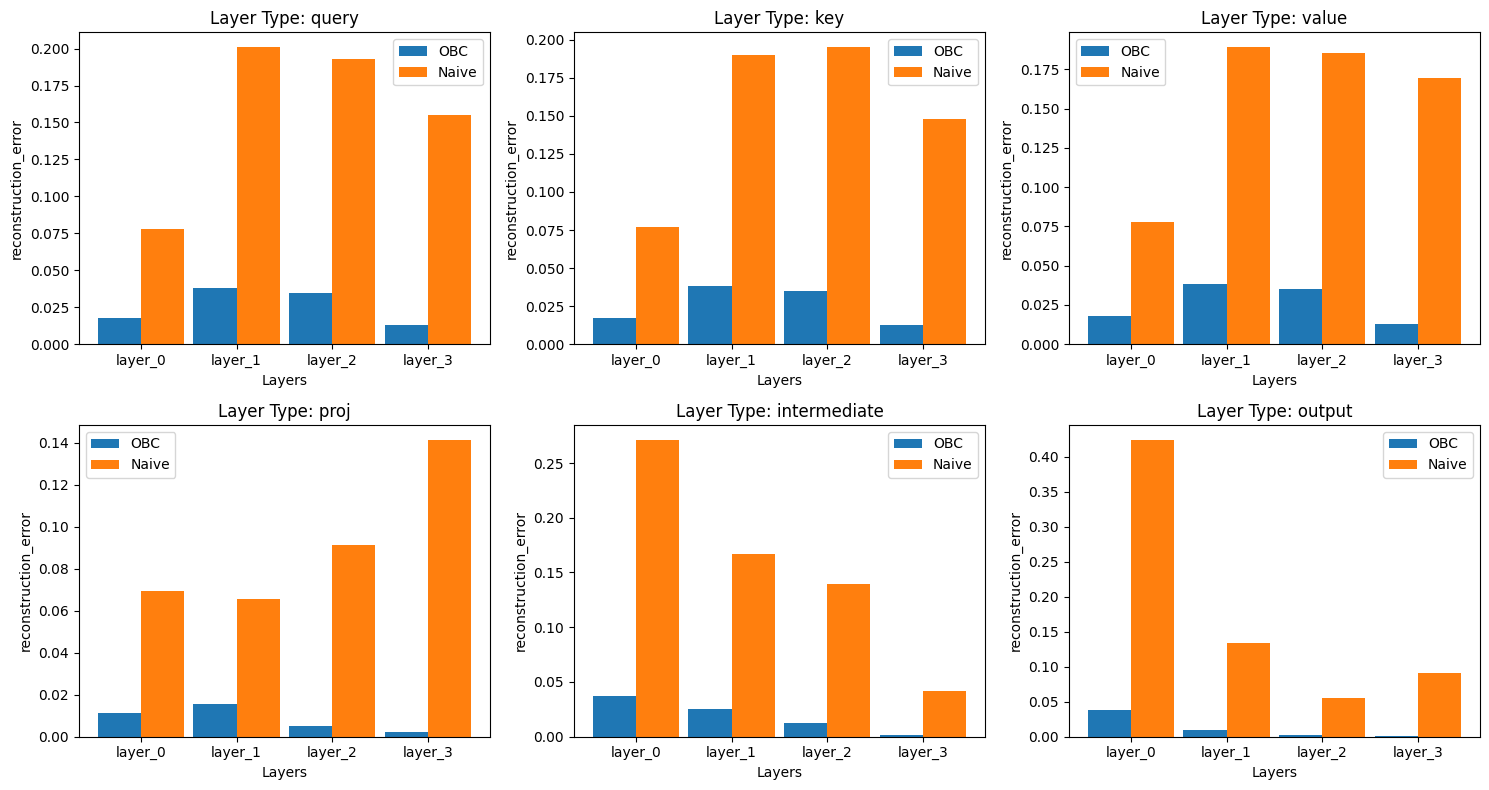

In [162]:
# target = 'weight_approximation_error'
target = 'reconstruction_error'

# Define the grid layout (2 rows, dynamic columns based on number of layer_types)
rows = 2
cols = (len(layer_types) + 1) // 2  # Ensures enough columns for all plots

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of multiple subplots

for i, layer_type in enumerate(layer_types):
    values_OBC = []
    values_naive = []
    categories = []

    for layer in layer_idx:
        values_OBC.append(results[target+"_OBC"][layer][layer_type])
        values_naive.append(results[target+"_naive"][layer][layer_type])
        categories.append(layer)

    x = np.arange(len(categories))  # X locations for the bars
    width = 0.45 # Width of bars

    ax = axes[i]  # Select subplot
    bars1 = ax.bar(x - width/2, values_OBC, width, label='OBC', color='tab:blue')
    bars2 = ax.bar(x + width/2, values_naive, width, label='Naive', color='tab:orange')

    # Formatting
    ax.set_title(f'Layer Type: {layer_type}')
    ax.set_xlabel('Layers')
    ax.set_ylabel(target)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

# Remove empty subplots if the number of layer_types is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('figures/bar_' + target + '_' + str(quantization_grid) + '.png', dpi=300)

In [163]:
weight_distances = list()

for layer_idx in range(4) :
    layer_OBC = model_OBC.bert.encoder.layer[layer_idx]
    layer_naive = model_naive.bert.encoder.layer[layer_idx]

    weight_distances.append(np.sum((layer_OBC.attention.self.query.weight.clone().detach().numpy() - layer_naive.attention.self.query.weight.clone().detach().numpy())**2, axis=0))
    weight_distances.append(np.sum((layer_OBC.attention.self.key.weight.clone().detach().numpy() - layer_naive.attention.self.key.weight.clone().detach().numpy())**2, axis=0))
    weight_distances.append(np.sum((layer_OBC.attention.self.value.weight.clone().detach().numpy() - layer_naive.attention.self.value.weight.clone().detach().numpy())**2, axis=0))
    weight_distances.append(np.sum((layer_OBC.attention.output.dense.weight.clone().detach().numpy() - layer_naive.attention.output.dense.weight.clone().detach().numpy())**2, axis=0))
    weight_distances.append(np.sum((layer_OBC.intermediate.dense.weight.clone().detach().numpy() - layer_naive.intermediate.dense.weight.clone().detach().numpy())**2, axis=0)) 
    weight_distances.append(np.sum((layer_OBC.output.dense.weight.clone().detach().numpy() - layer_naive.output.dense.weight.clone().detach().numpy())**2, axis=0))

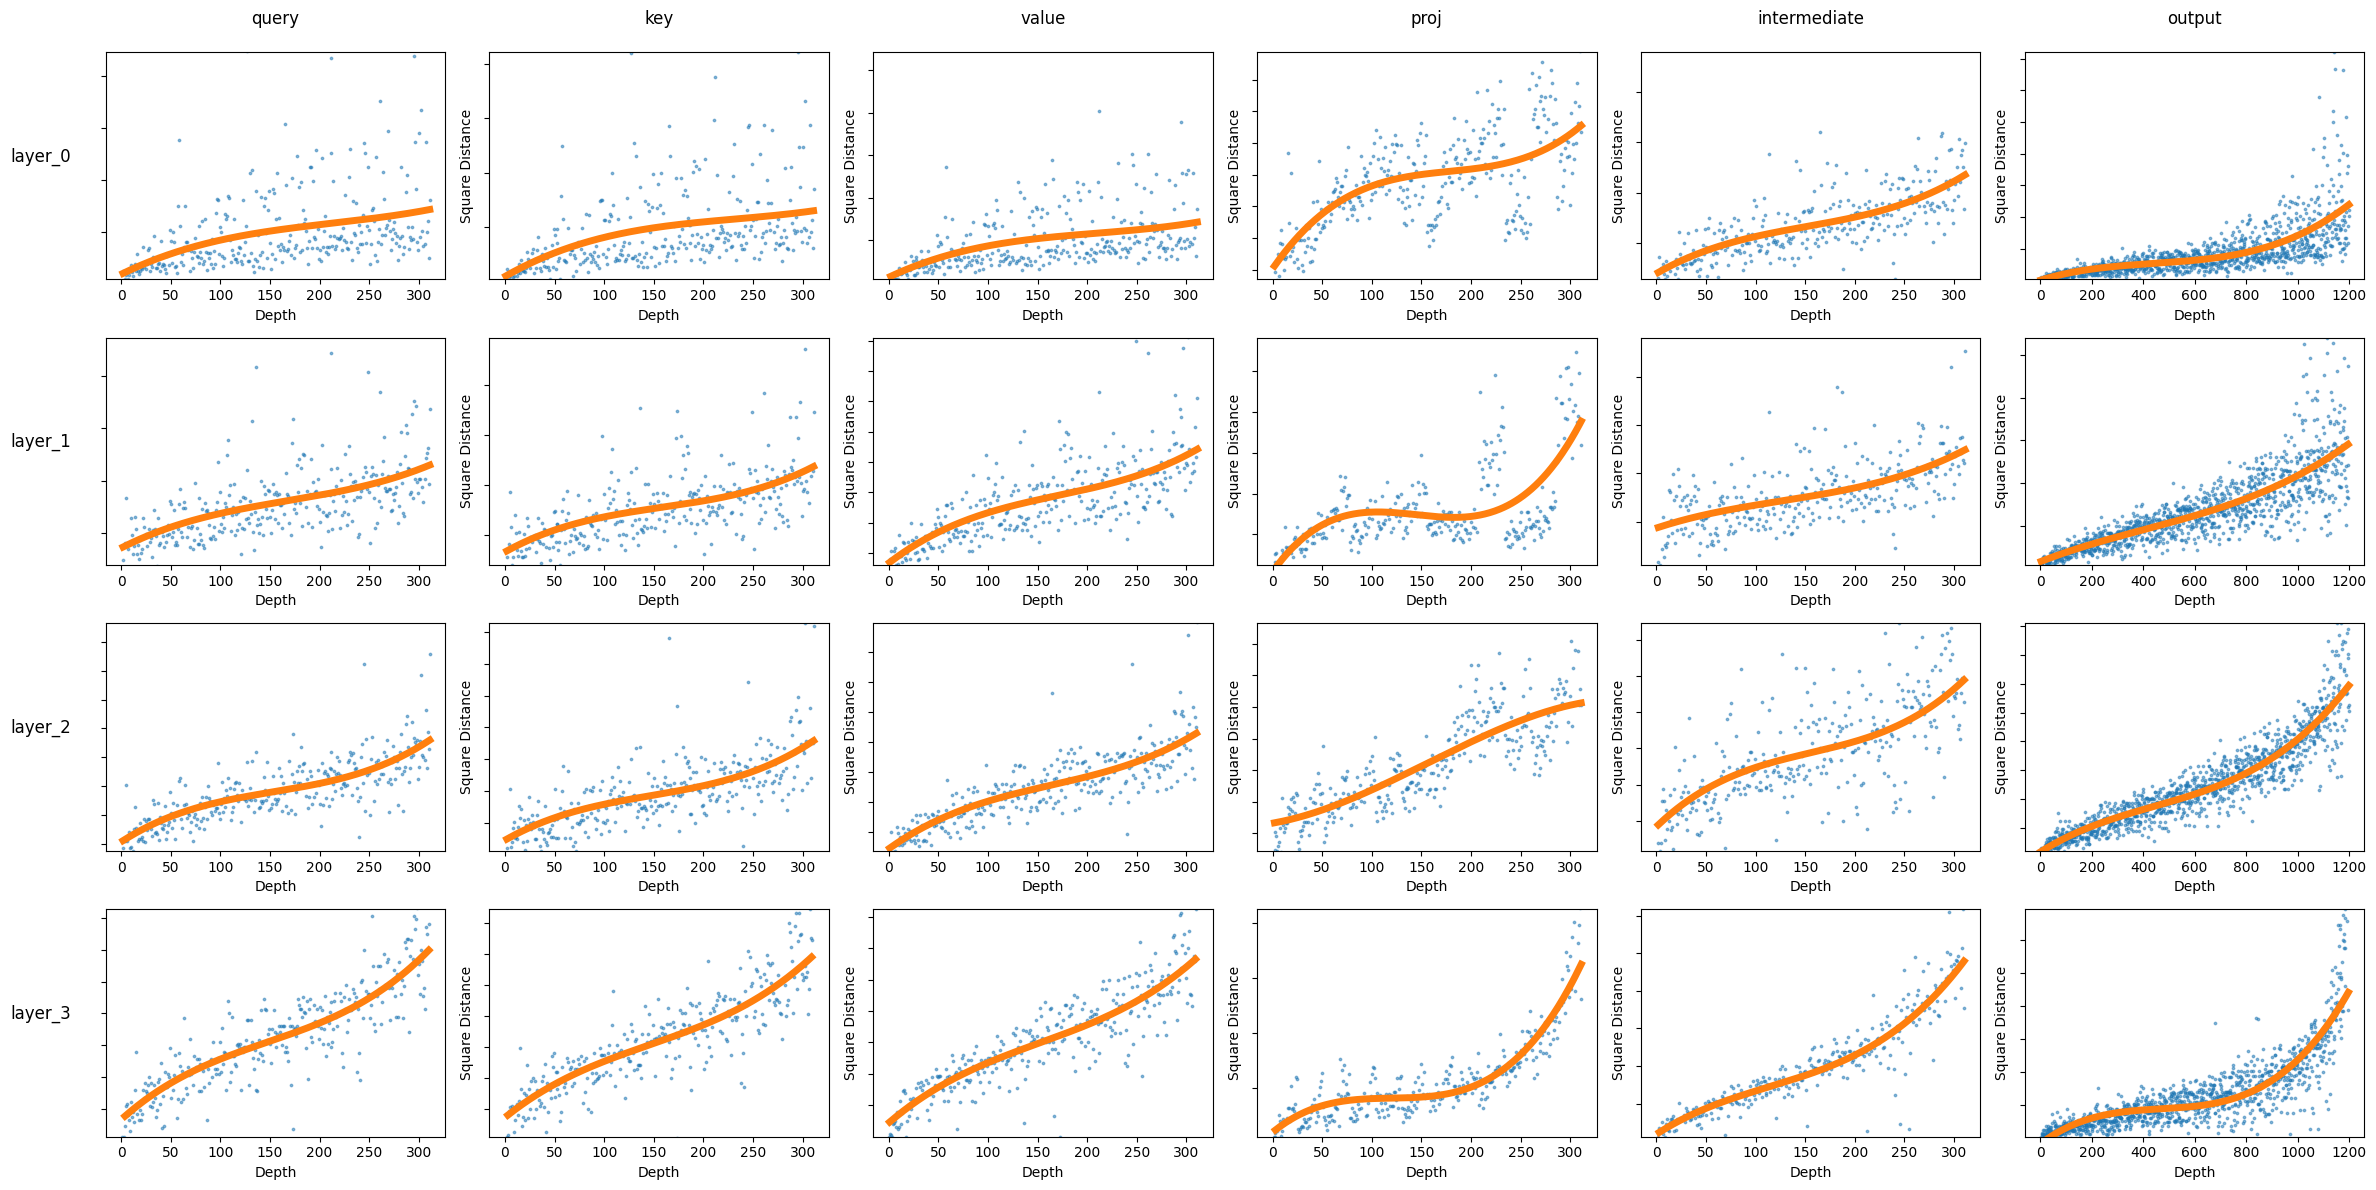

In [164]:
num_plots = len(weight_distances)
cols = 6  # Desired number of columns
rows = int(np.ceil(num_plots / cols))

# Example labels for columns and rows (ensure lengths match cols and rows)
layer_idx = ['layer_0', 'layer_1', 'layer_2', 'layer_3']
layer_types = ["query", "key", "value", "proj", "intermediate", "output"]

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()  # Flatten for easier indexing

for i, weight_distance in enumerate(weight_distances):
    ax = axes[i]
    
    # Scatter plot
    ax.scatter(range(len(weight_distance)), weight_distance, alpha=0.5, s=3)

    
    # Compute percentiles for y-axis limits
    Q1 = np.percentile(weight_distance, 1)
    Q3 = np.percentile(weight_distance, 99)
    ax.set_ylim([Q1, Q3])
    
    # Filter data and fit line
    x = np.arange(len(weight_distance))
    mask = (weight_distance > Q1) & (weight_distance < Q3)
    x_filtered = x[mask]
    filtered_weight_distance = weight_distance[mask]
    
    if len(x_filtered) > 1:  # Ensure enough data points to fit a line
        coefficients = np.polyfit(x_filtered, filtered_weight_distance, 3)
        poly = np.poly1d(coefficients)
        y_fit = poly(x_filtered)
        ax.plot(x_filtered, y_fit, color='tab:orange', linewidth=5)
    
    ax.set_xlabel('Depth')
    ax.set_ylabel('Square Distance')

    ax.set_yticklabels([])

    
# Set column titles (for the first row only)
for col in range(cols):
    idx = col  # First row indices: 0,1,...,cols-1
    if idx < len(axes):
        axes[idx].set_title(layer_types[col], pad=20, fontsize=12)

# Set row labels (for the first column of each row)
for row in range(rows):
    idx = row * cols  # First column indices: 0, cols, 2*cols, ...
    if idx < len(axes):
        axes[idx].set_ylabel(layer_idx[row], rotation=0, labelpad=40, fontsize=12)

# Remove any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig('figures/distance_to_naive_' + str(quantization_grid) + '.png', dpi=300)